In [37]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Bidirectional, TimeDistributed,Conv1D, MaxPooling1D, Input, concatenate
from keras.layers.recurrent import SimpleRNN
from keras.layers import GRU, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import keras
import os
import tarfile
import re
import pandas as pd
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import KFold
from keras_self_attention import SeqSelfAttention
import statistics

max_length = 50
vocab_size = 2000

In [34]:
def RNN(maxlen = 50, max_features = 4590, embed_size =32):
    model = Sequential()
    model.add(Embedding(max_features, embed_size, input_length=maxlen))
#     model.add(Dropout(0.5))
    model.add(GRU(16,dropout=0.2,return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Flatten())
#     model.add(Dense(8, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())

    return model

def CNN(maxlen=50, max_features=4590, embed_size=32):
    # Inputs
    comment_seq = Input(shape=[maxlen], name='x_seq')

    # Embeddings layers
    emb_comment = Embedding(max_features, embed_size)(comment_seq)

    # conv layers
    convs = []
#     filter_sizes = [2, 3, 4, 5]
    filter_sizes = [2, 3]

    for fsz in filter_sizes:
        l_conv = Conv1D(filters=10, kernel_size=fsz, activation='relu')(emb_comment)
        l_pool = MaxPooling1D(maxlen - fsz + 1)(l_conv)
        l_pool = Flatten()(l_pool)
        convs.append(l_pool)
    merge = concatenate(convs, axis=1)

    out = Dropout(0.2)(merge)
    output = Dense(16, activation='relu')(out)

    output = Dense(units=1, activation='sigmoid')(output)

    model = Model([comment_seq], output)
    print(model.summary())
    return model


def embedding(maxlen=50, max_features=4590, embed_size=16):
    # define the model
    model = Sequential()
    model.add(Embedding(max_features, embed_size, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # summarize the model
    print(model.summary())
    return model

    
def model_fit(model,padded_docs,labels,train_index,test_index, epochs = 5):
    len_train = len(train_index)
    len_test = len(test_index)
    x_test =  np.zeros(shape = (len_test,len(padded_docs[0])))
    y_test = np.zeros(shape = (len_test))
    x_train = np.zeros(shape = (len_train,len(padded_docs[0])))
    y_train = np.zeros(shape = (len_train))
    i = 0
    for tri in train_index:
        x_train[i] = padded_docs[tri]
        y_train[i] = labels[tri]
        i+=1
    j = 0
    for ti in test_index:
        x_test[j] = padded_docs[ti]
        y_test[j] =  labels[ti]
        j +=1
        
    print("Test set from ",test_index[0], " to ",test_index[-1])

    model.fit(x_train, y_train,epochs=epochs)
    eva = model.evaluate(x_test,y_test)
    print('loss: ',eva[0])
    print('accuracy: ',eva[1])
    print('precision: ',eva[2])
    print('recall: ',eva[3])
    print('f1-score: ',(2*eva[3]*eva[2])/(eva[3]+eva[2]))
    return model ,eva

def model_fit_no_test(model,x_train,y_train, epochs = 5):
    
    model.fit(x_train, y_train,epochs=epochs)
    return model 

import numpy
def predict_test(model, testData):
    test = numpy.reshape(testData,(1,testData.shape[0]))
    pr = model.predict(test)
    re = []
    if (pr >= 0.5):
        return ("yes")
    else:
        return ("no")
    
def predict_train(model, testData, truth):
    test = numpy.reshape(testData,(1,testData.shape[0]))
    pr = model.predict(test)
    print("==================")
    print("truth = ",truth )
    print("predict = ",pr )
    if (pr >= 0.5 and truth == 1) or (pr< 0.5 and truth ==0):
        print("true")
        return 1
    else:
        print("false")
        return 0
    
def write_result(predict, outPath,inpath ="assets/test_set_0520.csv"):
    dataframe_in = pd.read_csv(inpath, na_filter = False)
    dataframe_in["Expected"] = predict
    dataframe_in.to_csv(outPath)

def getMedian(textList):
     return statistics.median(textList)

In [58]:
def demostrateData():
    SPL = "<SPL>"
    path = "csv/trimedValues2.csv"
    train_file = path
    dataframe = pd.read_csv(path, na_filter = False)
    docs = []
    labels = []
    for i,data in dataframe.iterrows():
        d = data["comment"]
        c = data["code"]
        s = []
        s =  d+" "+SPL+" "+c # comment and code together
        docs.append(s)
        l = 1 if data["non-information"] == "yes" else 0
        labels.append(l)
    # integer encode the documents
    vocab_size = 2000
    encoded_docs = [one_hot(d, vocab_size) for d in docs]
    # pad documents to a max length of 41 words
    # The langest sentence contains 200 words but the Average is 21. If  padding all sentence to length of langest one, most of sentence
    # will be 0. That is not good for RNN, so we set padding length to 50
    summ = 0 
    li = []
    for t in encoded_docs:
        li.append(len(t))
        summ += len(t)
    avg = summ/len(encoded_docs)
    print("avg =", avg )
    m = getMedian(li)
    print("median = ",m)
    maxLen = len(max(docs, key=len).split())
    print("max = ",maxLen)
    li.sort()
    ## plot graph
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('ggplot')

    x = range(len(encoded_docs))

    plt.bar(x, li, color='green')

    plt.show()

avg = 21.787185354691076
median =  18
max =  199


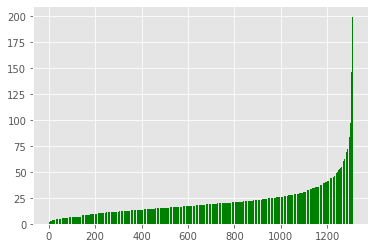

In [59]:
demostrateData()

The most length of given training sentence is less than 50. So we set 50 as padding length. 

In [30]:
# define documents
## read train Data
def read_train_Data():
    SPL = "<SPL>"
    path = "csv/trimedValues2.csv"
    train_file = path
    dataframe = pd.read_csv(path, na_filter = False)
    docs = []
    labels = []
    for i,data in dataframe.iterrows():
        d = data["comment"]
        c = data["code"]
        s = []
        s =  d+" "+SPL+" "+c # comment and code together
        docs.append(s)
        l = 1 if data["non-information"] == "yes" else 0
        labels.append(l)
    # integer encode the documents
    vocab_size = 2000
    encoded_docs = [one_hot(d, vocab_size) for d in docs]
    # pad documents to a max length of 41 words
    # The langest sentence contains 200 words but the Average is 21. If  padding all sentence to length of langest one, most of sentence
    # will be 0. That is not good for RNN, so we set padding length to 50
    li = []
    for t in encoded_docs:
        li.append(len(t))
    m = getMedian(li)
    # max_length = len(max(docs, key=len).split())
    max_length = 50
    ##
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_docs, labels

In [4]:
# define documents
## read test Data
def read_test_Data():
    SPL = "<SPL>"
    tes_path = "csv/trimedValues3.csv"
    test_file = tes_path
    dataframe = pd.read_csv(test_file, na_filter = False)
    test_docs = []
    test_labels = []
    for i,data in dataframe.iterrows():
        d = data["comment"]
        c = data["code"]
        s = []
        s =  d+" "+SPL+" "+c # comment and code together
        test_docs.append(s)
    # integer encode the documents
    vocab_size = 2000
    test_encoded_docs = [one_hot(d, vocab_size) for d in test_docs]
    # pad documents to a max length of 41 words
    # The langest sentence contains 200 words but the Average is 21. If  padding all sentence to length of langest one, most of sentence
    # will be 0. That is not good for RNN, so we set padding length to 50
    summ = 0
    for i in test_docs:
        summ += len(i.split())
#     print(summ/len(test_docs))
    # max_length = len(max(docs, key=len).split())
    max_length = 50
    ##
    test_padded_docs = pad_sequences(test_encoded_docs, maxlen=max_length, padding='post')
    return test_padded_docs

In [41]:
# train CNN with training data

padded_docs,labels = read_train_Data()
model_CNN = CNN(max_length,vocab_size,32)
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])
model_CNN = model_fit_no_test(model_CNN,padded_docs,labels)


21.7673531655225
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_seq (InputLayer)              (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 50, 32)       64000       x_seq[0][0]                      
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 49, 10)       650         embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 48, 10)       970         embedding_10[0][0]               
___________________________________________________________________________

In [90]:
## CNN test
test_padded_docs = read_test_Data()
outPath = "result/CNN-Result.txt"
i = []
for tr in (test_padded_docs):
    i.append(predict_test(model_CNN,tr))
print("CNN Predicted non-informative ",i)
write_result(i, outPath)

CNN Predicted non-informative  ['no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 

In [64]:
# train RNN with training data
padded_docs,labels = read_train_Data()
model = RNN(max_length,vocab_size,32)
learning_rate = 0.0002
adam = Adam(
    learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False
    )
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])
model = model_fit_no_test(model,padded_docs,labels, 20)

18
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 50, 32)            64000     
_________________________________________________________________
gru_39 (GRU)                 (None, 50, 16)            2352      
_________________________________________________________________
seq_self_attention_38 (SeqSe (None, 50, 16)            1089      
_________________________________________________________________
flatten_61 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 801       
Total params: 68,242
Trainable params: 68,242
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1311/1311 [==============================] - 9s 7ms/step - loss: 0.6819 - accuracy: 0.6857 - pre

In [65]:
## RNN test
test_padded_docs = read_test_Data()

i = []
for tr in (test_padded_docs):
    i.append(predict_test(model,tr))
print("RNN Predicted non-informative ",i)
outPath = "result/RNN-Result.txt"
write_result(i, outPath,)

RNN Predicted non-informative  ['no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 

In [58]:
# train embedding with training data
padded_docs,labels = read_train_Data()
model_em = embedding(max_length,vocab_size,32)
model_em.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])
model_em = model_fit_no_test(model_em,padded_docs,labels)


21.7673531655225
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 32)            64000     
_________________________________________________________________
flatten_18 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 1601      
Total params: 65,601
Trainable params: 65,601
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1311/1311 [==============================] - 1s 640us/step - loss: 0.6330 - accuracy: 0.6972 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00
Epoch 2/5
1311/1311 [==============================] - 0s 194us/step - loss: 0.5432 - accuracy: 0.7429 - precision_14: 0.7273 - recall_14: 0.1698
Epoch 3/5
1311/1311 [==============================] - 0s 

In [92]:
## embedding test
test_padded_docs = read_test_Data()

i = []
for tr in (test_padded_docs):
    i.append(predict_test(model_em,tr))
print("Embedding Predicted non-informative ",i)
outPath = "result/Embedding-Result.txt"
write_result(i, outPath)

Embedding Predicted non-informative  ['no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'n

In [62]:
# CNN train with split 
max_length = 50
vocab_size = 2000
padded_docs, labels = read_train_Data()
i = 0
n_split=5
loss = 0
accuracy = 0
precision = 0
recall = 0
f1_score = 0
for train_index,test_index in KFold(n_split).split(padded_docs):
    # define the model
    model = CNN(max_length,vocab_size,32)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

    model,eva = model_fit(model,padded_docs,labels,train_index,test_index)
    loss += eva[0]
    accuracy += eva[1]
    precision += eva[2]
    recall += eva[3]
    if precision + recall != 0:
        f1_score += (2*eva[3]*eva[2])/(eva[3]+eva[2])

print('total loss: ',loss/n_split)
print('total accuracy: ',accuracy/n_split)
print('total precision: ',precision/n_split)
print('total recall: ',recall/n_split)
print('total f1-score: ',f1_score/n_split)


18
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_seq (InputLayer)              (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_47 (Embedding)        (None, 50, 32)       64000       x_seq[0][0]                      
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 49, 10)       650         embedding_47[0][0]               
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 48, 10)       970         embedding_47[0][0]               
_________________________________________________________________________________________

Test set from  525  to  786
Epoch 1/5
1049/1049 [==============================] - 3s 3ms/step - loss: 0.6312 - accuracy: 0.7121 - precision_44: 0.0000e+00 - recall_44: 0.0000e+00
Epoch 2/5
1049/1049 [==============================] - 0s 475us/step - loss: 0.5514 - accuracy: 0.7121 - precision_44: 0.0000e+00 - recall_44: 0.0000e+00
Epoch 3/5
1049/1049 [==============================] - 1s 488us/step - loss: 0.4980 - accuracy: 0.7312 - precision_44: 1.0000 - recall_44: 0.0662
Epoch 4/5
1049/1049 [==============================] - 1s 487us/step - loss: 0.4494 - accuracy: 0.7598 - precision_44: 1.0000 - recall_44: 0.1656
Epoch 5/5
262/262 [==============================] - 2s 8ms/step
loss:  0.44777069883492154
accuracy:  0.7366412281990051
precision:  0.6499999761581421
recall:  0.1733333319425583
f1-score:  0.27368420667925697
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape  

1049/1049 [==============================] - 0s 450us/step - loss: 0.5628 - accuracy: 0.7112 - precision_46: 0.0000e+00 - recall_46: 0.0000e+00 0s - loss: 0.5725 - accuracy: 0.7058 - precision_46: 0.0000e+00 - recall_46: 0.0000e+0
Epoch 3/5
1049/1049 [==============================] - 0s 453us/step - loss: 0.5030 - accuracy: 0.7178 - precision_46: 1.0000 - recall_46: 0.0231
Epoch 4/5
1049/1049 [==============================] - 0s 456us/step - loss: 0.4377 - accuracy: 0.7703 - precision_46: 0.9079 - recall_46: 0.2277
Epoch 5/5
262/262 [==============================] - 2s 8ms/step
loss:  0.4956837246436199
accuracy:  0.7557252049446106
precision:  0.6666666865348816
recall:  0.2702702581882477
f1-score:  0.3846153756879133
total loss:  0.46709897007972784
total accuracy:  0.7757292509078979
total precision:  0.7023431420326233
total recall:  0.31229443848133087
total f1-score:  0.4232378991503197


In [11]:
# embedding train with split 
max_length = 50
vocab_size = 2000
padded_docs, labels = read_train_Data()
i = 0
n_split=5
loss = 0
accuracy = 0
precision = 0
recall = 0
f1_score = 0
for train_index,test_index in KFold(n_split).split(padded_docs):
    # define the model
    model = embedding(max_length,vocab_size,32)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

    model,eva = model_fit(model,padded_docs,labels,train_index,test_index)
    loss += eva[0]
    accuracy += eva[1]
    precision += eva[2]
    recall += eva[3]
    f1_score += (2*eva[3]*eva[2])/(eva[3]+eva[2])

print('total loss: ',loss/n_split)
print('total accuracy: ',accuracy/n_split)
print('total precision: ',precision/n_split)
print('total recall: ',recall/n_split)
print('total f1-score: ',f1_score/n_split)


21.7673531655225
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 32)            64000     
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1601      
Total params: 65,601
Trainable params: 65,601
Non-trainable params: 0
_________________________________________________________________
None
Test set from  0  to  262
Epoch 1/5
1048/1048 [==============================] - 1s 750us/step - loss: 0.6455 - accuracy: 0.6803 - precision_7: 0.4022 - recall_7: 0.1167
Epoch 2/5
1048/1048 [==============================] - 0s 219us/step - loss: 0.5608 - accuracy: 0.7242 - precision_7: 0.9118 - recall_7: 0.0978
Epoch 3/5
1048/1048 [=======================

1049/1049 [==============================] - 0s 212us/step - loss: 0.4174 - accuracy: 0.8027 - precision_11: 0.7553 - recall_11: 0.4686
Epoch 5/5
262/262 [==============================] - 0s 2ms/step
loss:  0.4723185619325128
accuracy:  0.7709923386573792
precision:  0.6666666865348816
recall:  0.37837839126586914
f1-score:  0.48275863638814365
total loss:  0.46716960070770075
total accuracy:  0.7833831548690796
total precision:  0.6571872889995575
total recall:  0.4432750344276428
total f1-score:  0.5204341262119808


In [44]:
# RNN train with split 
max_length = 50
vocab_size = 2000

padded_docs, labels = read_train_Data()
# attention will focus on specific words for example comment: auto generated method stub
i = 0
n_split=5
loss = 0
accuracy = 0
precision = 0
recall = 0
f1_score = 0
for train_index,test_index in KFold(n_split).split(padded_docs):
    # define the model
    model = RNN(max_length,vocab_size,32)
    learning_rate = 0.0002
    adam = Adam(
        learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False
        )
    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    min_delta=0,
                                                    patience=5,
                                                    verbose=0, mode='auto')
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

    model,eva = model_fit(model,padded_docs,labels,train_index,test_index, epochs=20)
    loss += eva[0]
    accuracy += eva[1]
    precision += eva[2]
    recall += eva[3]
    f1_score += (2*eva[3]*eva[2])/(eva[3]+eva[2])

print('total loss: ',loss/n_split)
print('total accuracy: ',accuracy/n_split)
print('total precision: ',precision/n_split)
print('total recall: ',recall/n_split)
print('total f1-score: ',f1_score/n_split)

18
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 50, 32)            64000     
_________________________________________________________________
gru_32 (GRU)                 (None, 50, 16)            2352      
_________________________________________________________________
seq_self_attention_31 (SeqSe (None, 50, 16)            1089      
_________________________________________________________________
flatten_36 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 801       
Total params: 68,242
Trainable params: 68,242
Non-trainable params: 0
_________________________________________________________________
None
Test set from  0  to  262
Epoch 1/20
1048/1048 [==============================] - 7s 7ms/step - loss: 0.686

262/262 [==============================] - 2s 9ms/step
loss:  1.0135951606371931
accuracy:  0.7786259651184082
precision:  0.550000011920929
recall:  0.515625
f1-score:  0.5322580700982497
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 50, 32)            64000     
_________________________________________________________________
gru_34 (GRU)                 (None, 50, 16)            2352      
_________________________________________________________________
seq_self_attention_33 (SeqSe (None, 50, 16)            1089      
_________________________________________________________________
flatten_38 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 801       
Total params: 68,242
Trainable params: 68,242
Non-trainable pa

1049/1049 [==============================] - 5s 5ms/step - loss: 0.2359 - accuracy: 0.9028 - precision_35: 0.8132 - recall_35: 0.8132
Epoch 19/20
1049/1049 [==============================] - 5s 5ms/step - loss: 0.2158 - accuracy: 0.9142 - precision_35: 0.8327 - recall_35: 0.8388
Epoch 20/20
262/262 [==============================] - 2s 9ms/step
loss:  0.5448283104951145
accuracy:  0.8015267252922058
precision:  0.7407407164573669
recall:  0.7692307829856873
f1-score:  0.7547169751482694
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 50, 32)            64000     
_________________________________________________________________
gru_36 (GRU)                 (None, 50, 16)            2352      
_________________________________________________________________
seq_self_attention_35 (SeqSe (None, 50, 16)            1089      
_______________________